In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from lib.read_data import dataset,Datasets

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# feature extractors
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
# finetuning
from sklearn.model_selection import GridSearchCV
# validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
% matplotlib inline

In [2]:
def read_data_set(data_table,test_size=0.25,BENCHMARK=False):
    '''
    convert a pandas dataframe data table into Datasets(dataset,dataset)
    '''
    train, test = train_test_split(data_table,test_size=0.25)
    train_x = train[[col for col in train.columns
    if col not in ['INFO','gavin_res']]]
    features = train_x.columns
    train_x = np.array(train_x)
    test_x = np.array(test[[col for col in train.columns
    if col not in ['INFO','gavin_res']]])
    train_y = np.array(train['INFO'],dtype=np.int8)
    test_y = np.array(test['INFO'],dtype=np.int8)

    # # check what columns are in the train Dataset
    # for i in range(0,len(train_x.columns),5):
    #     print(train_x.columns[i:i+5])

    if BENCHMARK:
        return Datasets(train=dataset(train_x,train_y,features),
                        test=dataset(test_x,test_y,features)),\
                        train['gavin_res'],\
                        test['gavin_res']
    return Datasets(train=dataset(train_x,train_y,features),
                    test=dataset(test_x,test_y,features))

def draw_roc_curve(fpr,tpr,score):
    '''
    draw roc curve
    '''
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def run_display_output(classifier,test,DRAW=False):
    '''
    get confusion matrix and auc score for test dataset
    (optional) draw roc curve
    '''
    pred = classifier.predict(test.values)
    tn, fp, fn, tp = confusion_matrix(test.labels,pred).ravel()#confusion matrix
    sensitivity = tp/(fn+tp)
    specificity = tn/(fp+tn)
    prods = classifier.predict_proba(test.values)[:,1]
    fpr, tpr, _ = metrics.roc_curve(test.labels, prods)
    score = metrics.auc(fpr,tpr) #auc score
    if DRAW:
        draw_roc_curve(fpr,tpr,score)

    return sensitivity, specificity, score

def read_gavin(gavin_res, labels):
    '''
    compare gavin results with labels for a certain subset of data
    '''
    gavin_res = gavin_res.replace('Pathogenic',1)
    gavin_res = gavin_res.replace('Benign',0)
    tn_g, fp_g, fn_g, tp_g = \
    confusion_matrix(labels, gavin_res.astype(np.int8)).ravel()
    sensitivity_g = tp_g/(fn_g+tp_g)
    specificity_g = tn_g/(fp_g+tn_g)
    return sensitivity_g, specificity_g

def display_res_gavin_and_best_model(param_grid,pipeline,mvid,filename=None,DRAW=False):
    '''
    use model defined by pipeline to fit mvid Dataset
    gridsearchCV determine the parameters given in param_grid
    (optional) save the model in path given in filename
    '''
    classifier = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid)

    print('Start training...')
    classifier.fit(mvid.train.values,mvid.train.labels)
    print('Model Description:\n',classifier.best_estimator_)
    if filename:
        pickle.dump(classifier,open(filename,'wb'))
        print('Saved model to path:',filename)
    sensitivity,specificity,score = run_display_output(classifier,mvid.test,DRAW)
    print('>>> best model results: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
    format(sensitivity,specificity,score,prec=3))
    return classifier


Dataset loaded. (186, 180)
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=52, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logr', LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
Saved model to path: model/pca_logr.sav


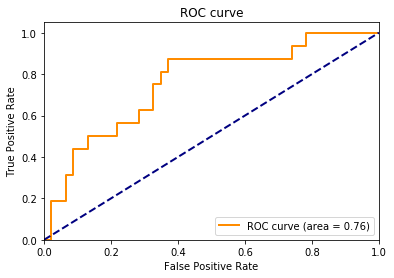

>>> best model results: sensitivity: 0.562	specificity: 0.783	auc:0.7567934782608696
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 4, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
Saved model to path: model/pca_ranfor.sav


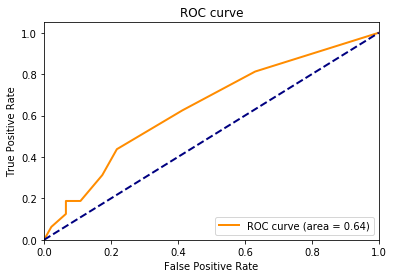

>>> best model results: sensitivity: 0.188	specificity: 0.935	auc:0.640625


In [5]:
if __name__=='__main__':

    # read data
    data = pd.read_csv('data/processed_table_with_gavin_res.csv',sep='\t')
    mvid,train_gavin, test_gavin = read_data_set(data,BENCHMARK=True)
    # print(data.head())
    # raise NotImplementedError # check the dataset loaded
    print('Dataset loaded.',mvid.train.values.shape)

# ================model selection==========================================
    # PCA + LogisticRegression
    # Parameters
    n_components = np.arange(2,mvid.train.num_features,10)
    class_weight = ['balanced',{1:4,0:1}]
    param_grid_logr = [{'pca__n_components':n_components,
                   'logr__penalty':['l1'],
                   'logr__C':[1,2,3,4,5],
                   'logr__class_weight':class_weight}]
    # pipeline
    pipeline_logr = Pipeline(steps=[('pca',PCA()),
                               ('logr',LogisticRegression())])
    # save model
    filename = os.path.join('model','pca_logr.sav')
    # display results
    classifier = display_res_gavin_and_best_model(param_grid_logr,
                                                  pipeline_logr,
                                                  mvid,
                                                  filename,
                                                  True)
    # PCA + RandomForest
    pipeline_ranfor = Pipeline(steps=[('pca',PCA()),
                                      ('ranfor',RandomForestClassifier())])
    n_estimators = [10,50,100]
    param_grid_ranfor = [{'pca__n_components':n_components,
                          'ranfor__n_estimators':n_estimators,
                          'ranfor__class_weight':class_weight}]
    filename = os.path.join('model','pca_ranfor.sav')
    display_res_gavin_and_best_model(param_grid_ranfor,
                                     pipeline_ranfor,
                                     mvid,
                                     filename,
                                     DRAW=True)

In [6]:
classifier.best_estimator_.steps[0][1].explained_variance_ratio_

array([ 0.11446475,  0.07636221,  0.05804041,  0.05523476,  0.05041665,
        0.04338717,  0.03850625,  0.03478538,  0.03366905,  0.03032564,
        0.0284446 ,  0.02510539,  0.02300675,  0.02243751,  0.02162231,
        0.01746792,  0.01489254,  0.01397095,  0.01301013,  0.01202601,
        0.01194007,  0.01149476,  0.01090866,  0.00987188,  0.00967678,
        0.00926567,  0.0085979 ,  0.00838809,  0.00786042,  0.00756404,
        0.00687107,  0.00653428,  0.00644125,  0.00610609,  0.00572965,
        0.00560721,  0.00545719,  0.00524003,  0.00495702,  0.00483888,
        0.00457575,  0.00451228,  0.00444919,  0.00420701,  0.00413303,
        0.00405203,  0.00395763,  0.00370168,  0.00348123,  0.00336395,
        0.00313611,  0.00295796])

In [7]:
mvid.train.features

Index(['Length', 'GC', 'CpG', 'priPhCons', 'mamPhCons', 'verPhCons',
       'priPhyloP', 'mamPhyloP', 'verPhyloP', 'GerpN',
       ...
       'nAA_S', 'nAA_T', 'nAA_V', 'nAA_W', 'nAA_Y', 'PolyPhenCat_benign',
       'PolyPhenCat_possibly_damaging', 'PolyPhenCat_probably_damaging',
       'SIFTcat_deleterious', 'SIFTcat_tolerated'],
      dtype='object', length=180)

In [8]:
# draw a overlapping bar graph for pandas dataframes
def overlapped_bar(df, show=False, width=0.9, alpha=.3,
                   title='', xlabel='', ylabel='', **plot_kwargs):
    """draw a stacked bar chart except bars on top of
    each other with transparency"""
    pl.figure(figsize=(20, 10))
    xlabel = xlabel or df.index.name
    N = len(df)
    M = len(df.columns)
    indices = np.arange(N)
    colors = ['steelblue','firebrick',
              'darksage','goldenrod','gray'] * int(M / 5. + 1)
    for i, label, color in zip(range(M), df.columns, colors):
        kwargs = plot_kwargs
        kwargs.update({'color': color, 'label': label})
        plt.bar(indices, df[label], width=width,
                alpha=alpha if i else 1, **kwargs)
        plt.xticks(indices + .5 * width,
                   ['{}'.format(idx) for idx in df.index.values])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    if show:
        plt.show()
    return plt.gcf()

In [9]:
def display_feature_importance(mean_x,x_cls,pca,classifier,LOG_TRANS=True,
                       TABLE=False,DRAW=False,SAVE_DRAW=False):
    '''
    visualize feature importance of a model consists of
    a feature extractor and a classifier by
    drawing/returning the coefficients.
    Input: mean_x, list of mean values of different classes (at least 2)
           x_cls, list of names of the classes
           pca, sklearn.Decomposition.PCA()
           classifier, sklearn models with .coef_ attribute
           LOG_TRANS, transform the importances in log-scale
           TABLE, return the importance value of each features
           DRAW, plot the importances
           SAVE_DRAW, save the plot as 'importances.png'
    Output: importances, list of importance values for each feature per class
            plot of feature importances
    '''
    importances = []
    length = pca.components_.shape[0]
    if classifier.coef_ is not None:
        importance = (pca.components_*classifier.coef_.reshape((length,1))).sum(axis=0)
    elif classifier.feature_importance_:
        importance = (pca.components_*classifier.feature_importances_.reashape((length,1))).sum(axis=0)
    for i in range(len(mean_x)):
        if LOG_TRANS:
            importances.append(np.log(abs(importance*mean_x[i])))
        else:
            importances.append(abs(importance*mean_x[i]))
    if DRAW:
        df = pd.DataFrame(np.matrix(importances).T, columns=x_cls)
#                   index=mean_x[0].keys())
        overlapped_bar(df, show=True)
        plt.show()
        if SAVE_DRAW:
            plt.savefig('importances.png')
    if TABLE:
        return importances


In [12]:
mean_x_path = list(np.mean(mvid.test.values[mvid.test.labels==1],axis=0))
mean_x_beni = list(np.mean(mvid.test.values[mvid.test.labels==0],axis=0))
mean_x = [mean_x_path,mean_x_beni]
x_cls = ['Pathogenic','Benign']
model_pca = classifier.best_estimator_.steps[0][1]
model_classifier = classifier.best_estimator_.steps[1][1]

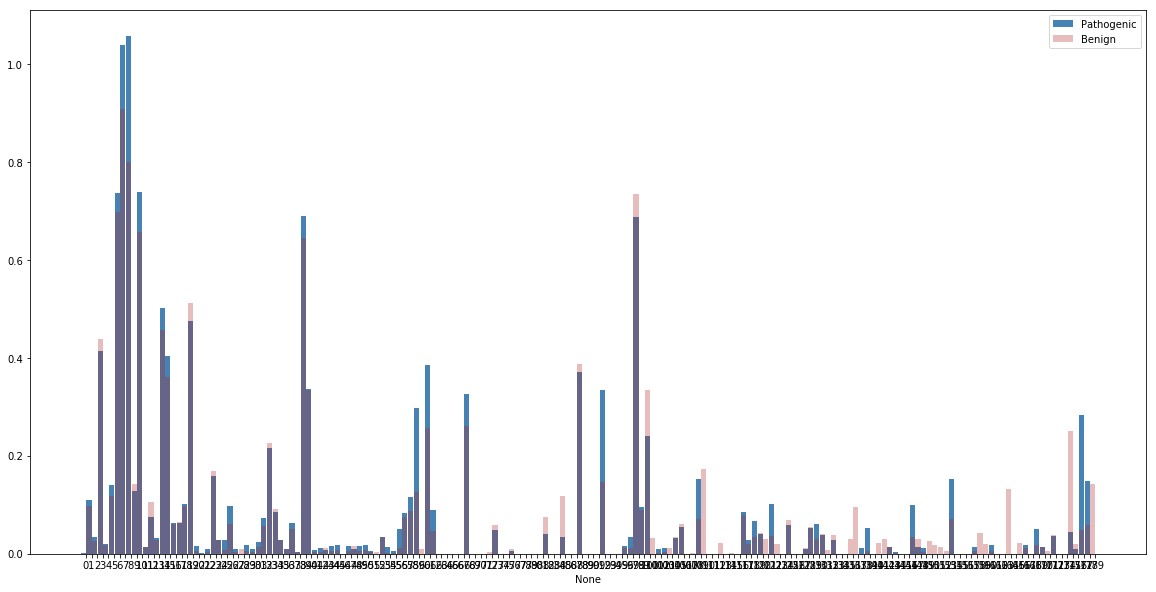

In [13]:
importance_table = display_feature_importance(mean_x,
                                              x_cls,
                                              model_pca,
                                              model_classifier,
                                              LOG_TRANS=False,
                                              DRAW=True,
                                              TABLE=True)

In [14]:
diff = importance_table[0]-importance_table[1]
sort_index = np.argsort(diff)

In [15]:
data.columns[sort_index[:20]]

Index(['nAA_Y', 'Consequence_STOP_GAINED', 'SIFTcat_deleterious', 'nAA_K',
       'oAA_D', 'isTv_False', 'ALT_AGAG', 'Type_INS', 'nAA_E', 'dnaRoll',
       'REF_TG', 'isTv_True', 'oAA_C', 'Segway_R1', 'GerpRS', 'oAA_I', 'oAA_S',
       'CpG', 'oAA_H', 'Segway_D'],
      dtype='object')

In [16]:
data.columns[sort_index[-20:]]

Index(['verPhCons', 'TFBSPeaks', 'mutIndex', 'PHRED', 'EncH3K4Me3', 'oAA_F',
       'bStatistic', 'oAA_P', 'Segway_R2', 'REF_AT', 'GerpN',
       'Consequence_SPLICE_SITE', 'oAA_Y', 'PolyPhenCat_probably_damaging',
       'SIFTval', 'priPhyloP', 'minDistTSE', 'ALT_GT',
       'PolyPhenCat_possibly_damaging', 'mamPhyloP'],
      dtype='object')

In [23]:
for i in range(0,len(mvid.train.features),5):
    print(mvid.train.features[i:i+5].values)

['Length' 'GC' 'CpG' 'priPhCons' 'mamPhCons']
['verPhCons' 'priPhyloP' 'mamPhyloP' 'verPhyloP' 'GerpN']
['GerpS' 'GerpRS' 'GerpRSpval' 'bStatistic' 'mutIndex']
['dnaHelT' 'dnaMGW' 'dnaProT' 'dnaRoll' 'fitCons']
['cHmmTssA' 'cHmmTssAFlnk' 'cHmmTxFlnk' 'cHmmTx' 'cHmmTxWk']
['cHmmEnhG' 'cHmmEnh' 'cHmmZnfRpts' 'cHmmHet' 'cHmmTssBiv']
['cHmmBivFlnk' 'cHmmEnhBiv' 'cHmmReprPC' 'cHmmReprPCWk' 'cHmmQuies']
['EncExp' 'EncH3K27Ac' 'EncH3K4Me1' 'EncH3K4Me3' 'EncNucleo']
['EncOCC' 'EncOCCombPVal' 'EncOCDNasePVal' 'EncOCFairePVal'
 'EncOCpolIIPVal']
['EncOCctcfPVal' 'EncOCmycPVal' 'EncOCDNaseSig' 'EncOCFaireSig'
 'EncOCpolIISig']
['EncOCctcfSig' 'EncOCmycSig' 'tOverlapMotifs' 'motifDist' 'TFBS']
['TFBSPeaks' 'TFBSPeaksMax' 'minDistTSS' 'minDistTSE' 'PolyPhenVal']
['SIFTval' 'PHRED' 'REF_A' 'REF_AA' 'REF_AC']
['REF_ACTTGC' 'REF_AG' 'REF_AT' 'REF_C' 'REF_CA']
['REF_CG' 'REF_CGGG' 'REF_CT' 'REF_G' 'REF_GA']
['REF_GAA' 'REF_T' 'REF_TA' 'REF_TACGGA' 'REF_TC']
['REF_TCTGA' 'REF_TG' 'ALT_A' 'ALT_AG' 'ALT_A

In [17]:
# read data file
datafolder = 'data/'
datafile = 'myo5b_variants_patho_benign_cadd1.3fullannot_v1.xlsx'
datatable = pd.ExcelFile(os.path.join(datafolder,datafile))
datatable_pd = datatable.parse(datatable.sheet_names[0])

In [21]:
new_data = datatable_pd[['INFO','RawScore']]
train,test = train_test_split(new_data)

In [28]:
logr = LogisticRegression()
logr.fit(train['RawScore'].values.reshape(-1,1),train['INFO'])
prediction = logr.predict(test['RawScore'].values.reshape(-1,1))
confusion_matrix(test['INFO'],prediction)

array([[48,  0],
       [13,  1]])

In [29]:
logr.coef_

array([[ 0.15198383]])